In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *
import os
import pickle

## Results

In [2]:
tasks = ['doubleTmaze', 'cylinder', 'permanence', 'thorndike']
model_types = ['sparse-AE', 'AE']

In [2]:
results = {}
for model_type in model_types:
    results[model_type] = {}
    for task in tasks:
        print(model_type, task)
        
        # Load dataset and model
        dataset, position = load_dataset(directory='datasets/' + task, task=task)
        model = Conv_AE(n_hidden=1000).to('cuda')
        model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

        # Get latent embeddings
        embeddings = get_latent_vectors(dataset, model)
        embeddings[embeddings < 1e-5] = 0
        
        # Generate ratemaps and cleaned ratemaps
        ratemaps = generate_ratemaps(embeddings, position, n_bins=60, filter_width=4, n_bins_padding=10)
        cleaned_ratemaps = clean_ratemaps(ratemaps)
        
        # Place field density
        all_num_fields, all_centroids, all_sizes = stats_place_fields(cleaned_ratemaps, min_pix_cluster=0.03)
        place_field_density = np.histogram(all_num_fields, bins=np.max(all_num_fields) + 1, density=True)[0]
        
        # Homogeneity in tiling of 2D space
        homogeneity_tiling = homogeneity_2Dtiling(all_centroids)
        
        # Distribution of distances to walls
        occupancy_map = generate_occupancy_map(position, n_bins=60, filter_width=0, n_bins_padding=10, norm=False)
        distances = dist_to_walls(all_centroids, occupancy_map)
        dist_size_corr_slope, b = np.polyfit(distances, all_sizes, 1)

        # Average spatial information
        unfiltered_ratemaps = generate_ratemaps(embeddings, position, n_bins=30, filter_width=0, n_bins_padding=0)
        cleaned_unfiltered_ratemaps = clean_ratemaps(unfiltered_ratemaps)
        occupancy_map_norm = generate_occupancy_map(position, n_bins=30, filter_width=0, n_bins_padding=0, norm=True)
        avg_spatial_info = np.mean(spatial_information(cleaned_unfiltered_ratemaps, occupancy_map_norm))
    
        # Linear decoding error
        #linear_score, baseline_score, ratio = linear_decoding_score(embeddings, position, n_baseline=100)
        norm_factor = (np.max(position) - np.min(position)) * np.sqrt(2)   # uses the diagonal of the square as max distance.
        mean_decoding_error_embeddings = linear_decoding_error(embeddings, position, norm=norm_factor)
        
        ratemaps_reshaped = ratemaps.reshape(ratemaps.shape[1] * ratemaps.shape[2], ratemaps.shape[0])
        pos_values = np.linspace(np.min(position), np.max(position), ratemaps.shape[1])
        position_for_ratemaps = np.array([[i, j] for i in pos_values for j in pos_values])
        mean_decoding_error_ratemaps = linear_decoding_error(ratemaps_reshaped, position_for_ratemaps, norm=norm_factor)
        
        # Store the results in the dictionary
        results[model_type][task] = {
            'ratemaps': cleaned_ratemaps,
            'place_field_density_hist': place_field_density,
            'homogeneity_2Dtiling': homogeneity_tiling,
            'distances_to_walls': distances,
            'all_sizes': all_sizes,
            'dist_size_corr_slope': dist_size_corr_slope,
            'avg_spatial_info': avg_spatial_info,
            #'linear_decoding_score': linear_score,
            #'linear_decoding_baseline_score': baseline_score,
            #'linear_decoding_ratio': ratio,
            'mean_decoding_error_embeddings': mean_decoding_error_embeddings,
            'mean_decoding_error_ratemaps': mean_decoding_error_ratemaps
        }

sparse-AE doubleTmaze
sparse-AE cylinder
sparse-AE permanence
sparse-AE thorndike
AE doubleTmaze
AE cylinder
AE permanence
AE thorndike


#### Save results

In [3]:
# Ensure the directory exists
os.makedirs('results', exist_ok=True)

# Save the results dictionary to a file in the 'results' folder
file_path = os.path.join('results', 'spatial_allModels.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

#### Load results

In [3]:
# Load and print the results to check
file_path = os.path.join('results', 'spatial_allModels.pkl')
with open(file_path, 'rb') as f:
    results = pickle.load(f)

## Plots

In [4]:
results['AE']['cylinder'].keys()

dict_keys(['ratemaps', 'place_field_density_hist', 'homogeneity_2Dtiling', 'distances_to_walls', 'all_sizes', 'dist_size_corr_slope', 'avg_spatial_info', 'mean_decoding_error_embeddings', 'mean_decoding_error_ratemaps'])

#### B - Ratemaps

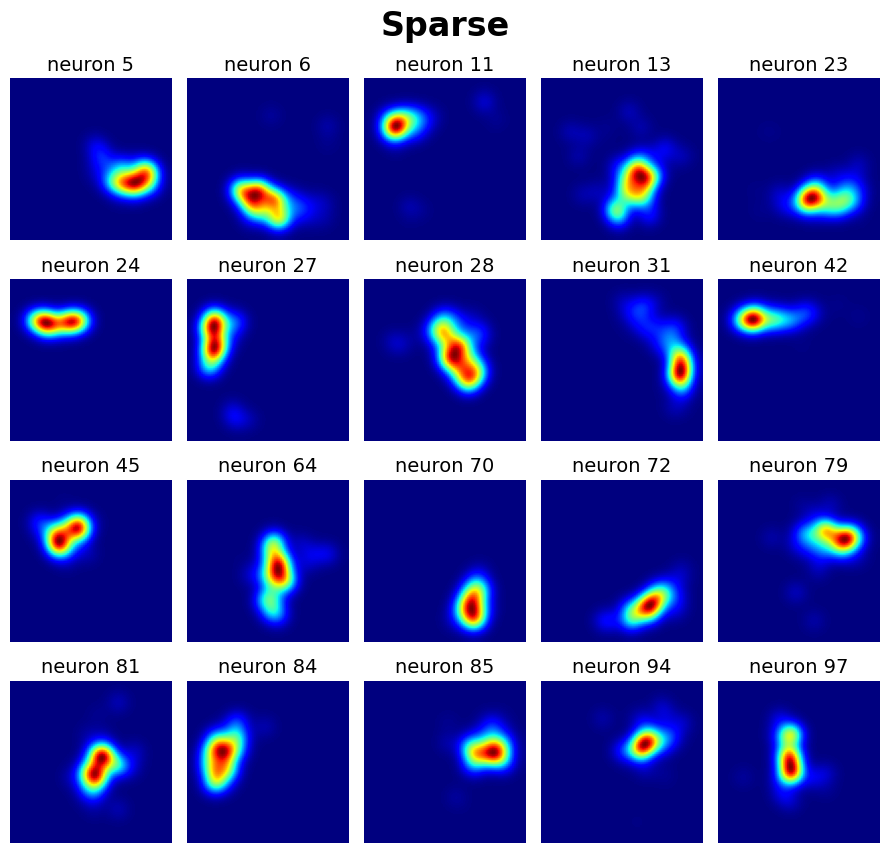

In [9]:
plt.figure(figsize=(9, 8.8))

plt.suptitle('Sparse', fontsize=24, fontweight='bold')

ratemaps_sparse = results[model_types[0]][tasks[2]]['ratemaps']

#all_num_fields, _, _ = stats_place_fields(ratemaps_sparse, min_pix_cluster=0.04)
#indxs_ratemaps_sparse = np.argwhere(all_num_fields == 1).flatten()[0:20]
indxs_ratemaps_sparse = [5, 6, 11, 13, 23, 24, 27, 28, 31, 42, 45, 64, 70, 72, 79, 81, 84, 85, 94, 97]

ratemaps_sparse = ratemaps_sparse[indxs_ratemaps_sparse]

for i, indx in enumerate(indxs_ratemaps_sparse):
    plt.subplot(4, 5, i+1)
    plt.title('neuron '+str(indx), fontsize=14)
    plt.imshow(ratemaps_sparse[i], cmap='jet', origin='lower')
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('plots/fig1/B_ratemaps_sparse.svg', dpi=600)
plt.show()

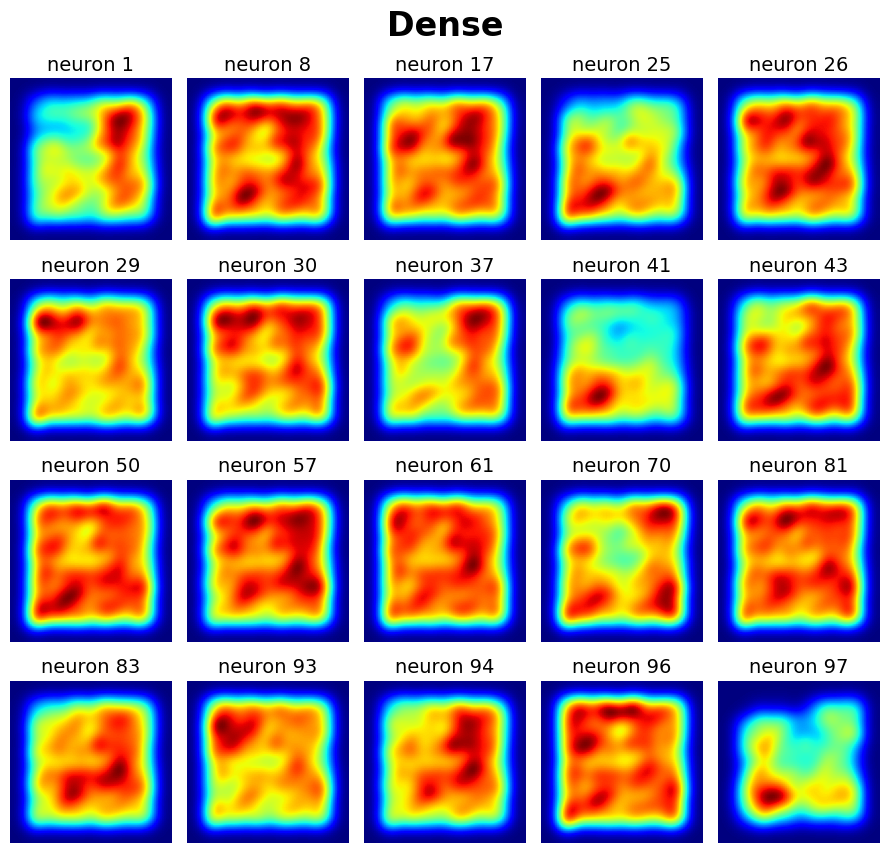

In [42]:
plt.figure(figsize=(9, 8.8))

plt.suptitle('Dense', fontsize=24, fontweight='bold')

ratemaps_dense = results[model_types[1]][tasks[2]]['ratemaps']

indxs_ratemaps_dense = [5, 6, 11, 13, 23, 24, 27, 28, 31, 42, 45, 64, 70, 72, 79, 81, 84, 85, 94, 97]
indxs_ratemaps_dense = np.sort(np.random.choice(np.arange(100), 20, replace=False))

ratemaps_dense = ratemaps_dense[indxs_ratemaps_dense]

for i, indx in enumerate(indxs_ratemaps_dense):
    plt.subplot(4, 5, i+1)
    plt.title('neuron '+str(indx), fontsize=14)
    plt.imshow(ratemaps_dense[i], cmap='jet', origin='lower')
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('plots/fig1/B_ratemaps_dense.svg', dpi=600)
plt.show()

#### C - Place field histogram

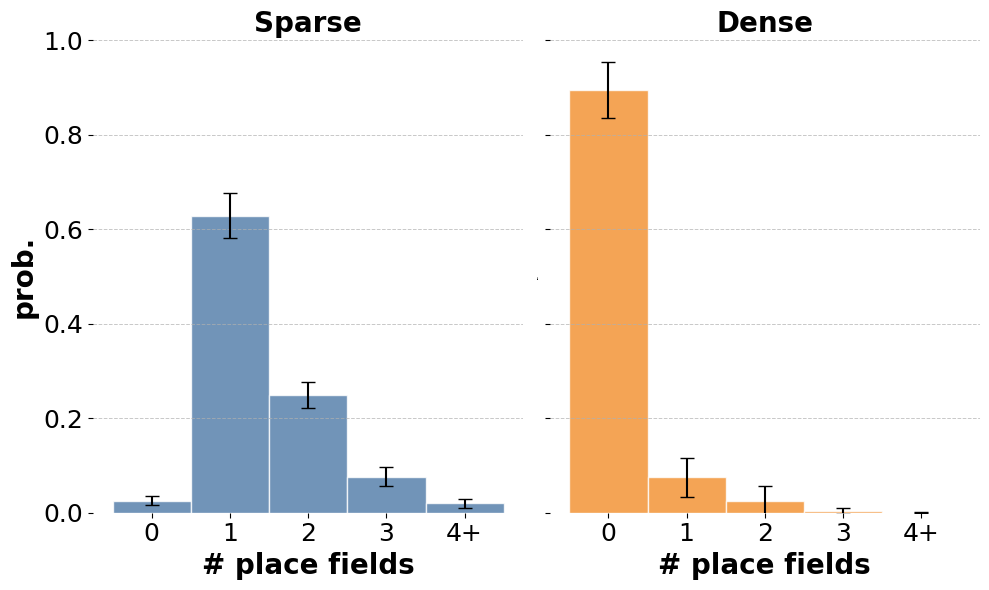

In [91]:
# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B'}
edge_color = '#ffffff'
alpha_value = 0.8

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

title_labels = ['Sparse', 'Dense']
for idx, model_type in enumerate(model_types):
    # Extract histograms for the given model type
    histograms = [results[model_type][task]['place_field_density_hist'] for task in tasks]

    # Find the maximum length of the histograms
    max_length = max(len(hist) for hist in histograms)

    # Pad histograms with zeros to make them the same length
    padded_histograms = np.array([np.pad(hist, (0, max_length - len(hist)), 'constant') for hist in histograms])

    # Collapse bins above 4 place fields into a single bin
    collapsed_histograms = np.zeros((len(padded_histograms), 5))
    collapsed_histograms[:, :4] = padded_histograms[:, :4]
    collapsed_histograms[:, 4] = padded_histograms[:, 4:].sum(axis=1)

    # Compute the mean and standard deviation across the histograms
    mean_counts = np.mean(collapsed_histograms, axis=0)
    std_counts = np.std(collapsed_histograms, axis=0)

    # Normalize the mean counts to sum to 1 (as probabilities)
    mean_counts /= mean_counts.sum()

    # Create the bar plot with error bars
    axs[idx].bar(np.arange(5), mean_counts, yerr=std_counts, width=1, color=colors[model_type], alpha=alpha_value, edgecolor=edge_color, capsize=5)
    
    axs[idx].set_xlabel('# place fields', fontsize=20, fontweight='bold')
    axs[idx].set_ylabel('prob.', fontsize=20 if idx == 0 else 0, fontweight='bold')
    axs[idx].set_yticks(np.linspace(0, 1, 6))
    axs[idx].set_yticklabels(np.linspace(0, 1, 6).round(1), fontsize=18)
    axs[idx].set_xticks(np.arange(5))
    axs[idx].set_xticklabels([0, 1, 2, 3, '4+'], fontsize=18)
    axs[idx].set_ylim(0, 1)
    axs[idx].set_title(title_labels[idx], fontsize=20, fontweight='bold')
    
    # Add gridlines
    axs[idx].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Despine and customize tick params
    sb.despine(ax=axs[idx], left=True, bottom=True)
    axs[idx].tick_params(axis='y', labelsize=18 if idx == 0 else 0)

# Overall layout adjustments
plt.tight_layout()

plt.savefig('plots/fig1/C_placeFieldDistr.svg', dpi=600)

plt.show()

#### D and E - Spatial info and linear decoding

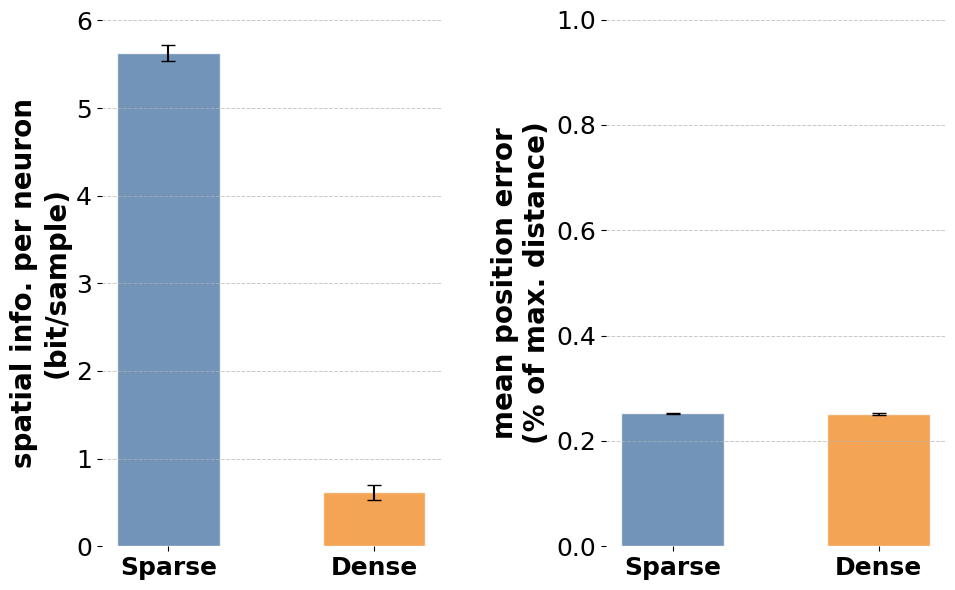

In [107]:
# Extract data for spatial info and mean decoding error ratemaps
spatial_info_sparse = [results[model_types[0]][task]['avg_spatial_info'] for task in tasks]
spatial_info_dense = [results[model_types[1]][task]['avg_spatial_info'] for task in tasks]

mean_decoding_error_ratemaps_sparse = [results[model_types[0]][task]['mean_decoding_error_ratemaps'] for task in tasks]
mean_decoding_error_ratemaps_dense = [results[model_types[1]][task]['mean_decoding_error_ratemaps'] for task in tasks]

# Custom style settings
colors = {'sparse': '#4E79A7', 'dense': '#F28E2B'}
edge_color = '#ffffff'
alpha_value = 0.8
bar_width = 0.5  # Narrower bars

# Compute means and standard deviations
mean_sparse_spatial = np.mean(spatial_info_sparse)
std_sparse_spatial = np.std(spatial_info_sparse)
mean_dense_spatial = np.mean(spatial_info_dense)
std_dense_spatial = np.std(spatial_info_dense)

mean_sparse_rate = np.mean(mean_decoding_error_ratemaps_sparse)
std_sparse_rate = np.std(mean_decoding_error_ratemaps_sparse)
mean_dense_rate = np.mean(mean_decoding_error_ratemaps_dense)
std_dense_rate = np.std(mean_decoding_error_ratemaps_dense)

means_spatial = [mean_sparse_spatial, mean_dense_spatial]
stds_spatial = [std_sparse_spatial, std_dense_spatial]

means_rate = [mean_sparse_rate, mean_dense_rate]
stds_rate = [std_sparse_rate, std_dense_rate]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# Spatial info plot
bars_spatial = axs[0].bar(['Sparse', 'Dense'], means_spatial, yerr=stds_spatial, color=[colors['sparse'], colors['dense']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
axs[0].set_ylabel('spatial info. per neuron\n(bit/sample)', fontsize=20, fontweight='bold')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Mean decoding error ratemaps plot
bars_rate = axs[1].bar(['Sparse', 'Dense'], means_rate, yerr=stds_rate, color=[colors['sparse'], colors['dense']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
axs[1].set_ylabel('mean position error\n(% of max. distance)', fontsize=20, fontweight='bold')
axs[1].set_xticks([0, 1])
axs[1].set_ylim(0, 1)
axs[1].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Despine for a cleaner look
for ax in axs:
    sb.despine(ax=ax, left=True, bottom=True)

# Adjust the space between subplots
plt.subplots_adjust(wspace=15)

plt.tight_layout()

plt.savefig('plots/fig1/D_info_and_decoding_ratemaps.svg', dpi=600)

plt.show()

#### Baseline mean decoding error

In [30]:
def shuffle_matrix(M):
    # Get the shape of the matrix
    original_shape = M.shape
    
    # Flatten the matrix into a 1D array
    flattened = M.flatten()
    
    # Shuffle the 1D array
    np.random.shuffle(flattened)
    
    # Reshape the shuffled 1D array back into the original matrix shape
    shuffled_M = flattened.reshape(original_shape)
    
    return shuffled_M

In [31]:
errors = {}
for model_type in model_types:
    errors[model_type] = {}
    for task in tasks:
        print(model_type, task)
        
        # Load dataset and model
        dataset, position = load_dataset(directory='datasets/' + task, task=task)
        model = Conv_AE(n_hidden=1000).to('cuda')
        model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

        # Get latent embeddings
        embeddings = get_latent_vectors(dataset, model)
        embeddings[embeddings < 1e-5] = 0
        
        # Generate ratemaps
        ratemaps = generate_ratemaps(embeddings, position, n_bins=60, filter_width=4, n_bins_padding=10)
        ratemaps = clean_ratemaps(ratemaps)
        ratemaps_reshaped = ratemaps.reshape((ratemaps.shape[0], int(ratemaps.shape[1]*ratemaps.shape[2]))).T
        
        pos_values = np.linspace(np.min(position), np.max(position), ratemaps.shape[1])
        position_for_ratemaps = np.array([[i, j] for i in pos_values for j in pos_values])

        norm_factor = (np.max(position) - np.min(position)) * np.sqrt(2)
        
        mean_decoding_error_ratemaps = linear_decoding_error(ratemaps_reshaped, position_for_ratemaps, norm=norm_factor)
        
        mean_decoding_error_ratemaps_baselines = []
        for i in range(20):
            randomized_ratemaps = shuffle_matrix(ratemaps_reshaped)
            err = linear_decoding_error(randomized_ratemaps, position_for_ratemaps, norm=norm_factor)
            mean_decoding_error_ratemaps_baselines.append(err)
        
        # Store the results in the dictionary
        errors[model_type][task] = {
            'mean_decoding_error_ratemaps': mean_decoding_error_ratemaps,
            'mean_decoding_error_ratemaps_baselines': mean_decoding_error_ratemaps_baselines
        }

sparse-AE doubleTmaze
sparse-AE cylinder
sparse-AE permanence
sparse-AE thorndike
AE doubleTmaze
AE cylinder
AE permanence
AE thorndike


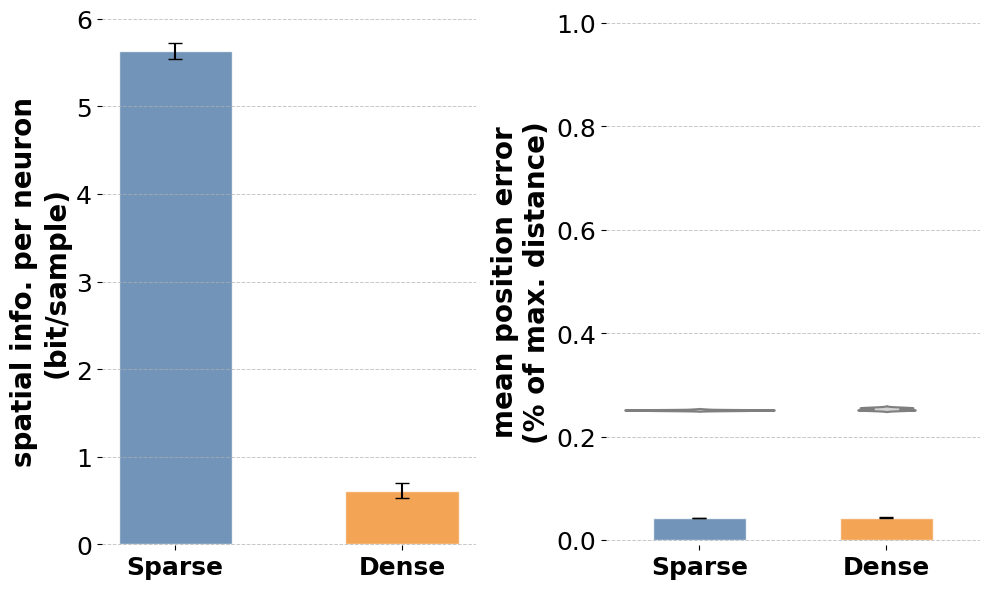

In [58]:
# Extract data for spatial info and mean decoding error ratemaps
spatial_info_sparse = [results['sparse-AE'][task]['avg_spatial_info'] for task in tasks]
spatial_info_dense = [results['AE'][task]['avg_spatial_info'] for task in tasks]

mean_decoding_error_ratemaps_sparse = [errors['sparse-AE'][task]['mean_decoding_error_ratemaps'] for task in tasks]
mean_decoding_error_ratemaps_dense = [errors['AE'][task]['mean_decoding_error_ratemaps'] for task in tasks]

# Extract mean decoding error ratemaps baselines
mean_decoding_error_ratemaps_baselines_sparse = []
mean_decoding_error_ratemaps_baselines_dense = []
for task in tasks:
    mean_decoding_error_ratemaps_baselines_sparse.extend(errors['sparse-AE'][task]['mean_decoding_error_ratemaps_baselines'])
    mean_decoding_error_ratemaps_baselines_dense.extend(errors['AE'][task]['mean_decoding_error_ratemaps_baselines'])

# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B'}
edge_color = '#ffffff'
alpha_value = 0.8
bar_width = 0.5  # Narrower bars

# Compute means and standard deviations
mean_sparse_spatial = np.mean(spatial_info_sparse)
std_sparse_spatial = np.std(spatial_info_sparse)
mean_dense_spatial = np.mean(spatial_info_dense)
std_dense_spatial = np.std(spatial_info_dense)

mean_sparse_rate = np.mean(mean_decoding_error_ratemaps_sparse)
std_sparse_rate = np.std(mean_decoding_error_ratemaps_sparse)
mean_dense_rate = np.mean(mean_decoding_error_ratemaps_dense)
std_dense_rate = np.std(mean_decoding_error_ratemaps_dense)

means_spatial = [mean_sparse_spatial, mean_dense_spatial]
stds_spatial = [std_sparse_spatial, std_dense_spatial]

means_rate = [mean_sparse_rate, mean_dense_rate]
stds_rate = [std_sparse_rate, std_dense_rate]

# Prepare data for the violin plot
violin_data = []
violin_data.extend([('Sparse', err) for err in mean_decoding_error_ratemaps_baselines_sparse])
violin_data.extend([('Dense', err) for err in mean_decoding_error_ratemaps_baselines_dense])

# Convert to DataFrame for seaborn
violin_df = pd.DataFrame(violin_data, columns=['Model Type', 'Error'])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# Spatial info plot
bars_spatial = axs[0].bar(['Sparse', 'Dense'], means_spatial, yerr=stds_spatial, color=[colors['sparse-AE'], colors['AE']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
axs[0].set_ylabel('spatial info. per neuron\n(bit/sample)', fontsize=20, fontweight='bold')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axs[0].set_ylim(-0.01,6.01)

# Mean decoding error ratemaps plot
bars_rate = axs[1].bar(['Sparse', 'Dense'], means_rate, yerr=stds_rate, color=[colors['sparse-AE'], colors['AE']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
sb.violinplot(x='Model Type', y='Error', data=violin_df, inner=None, color='lightgrey', alpha=0.3, ax=axs[1])
axs[1].set_ylabel('mean position error\n(% of max. distance)', fontsize=20, fontweight='bold')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axs[1].set_ylim(-0.01,1.01)
axs[1].set_xlabel('')

# Despine for a cleaner look
for ax in axs:
    sb.despine(ax=ax, left=True, bottom=True)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.4)

plt.tight_layout()
plt.savefig('plots/fig1/DE_error_decoding_ratemaps.svg', dpi=600)
plt.show()

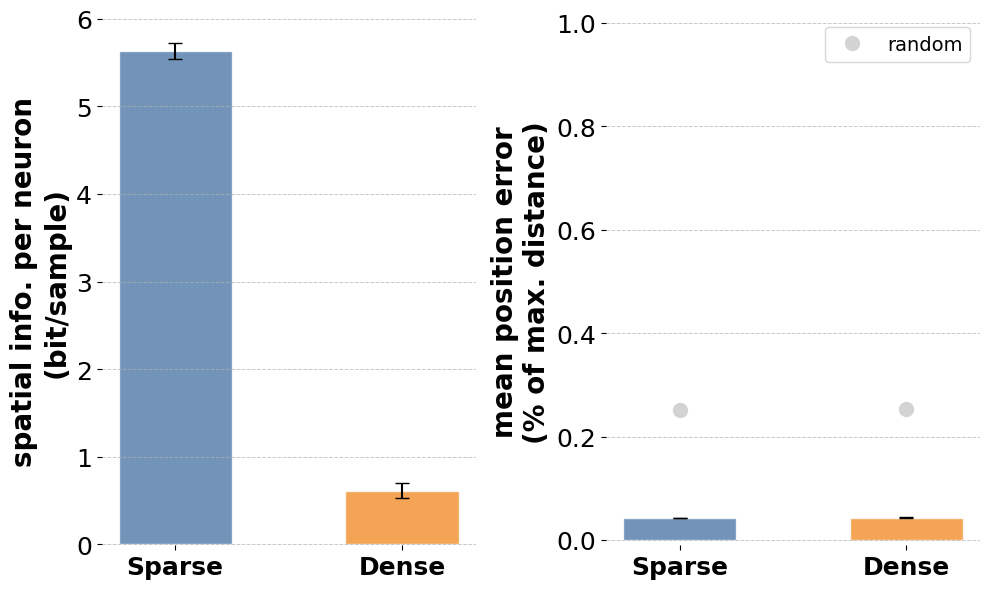

In [71]:
from matplotlib.lines import Line2D

# Extract data for spatial info and mean decoding error ratemaps
spatial_info_sparse = [results['sparse-AE'][task]['avg_spatial_info'] for task in tasks]
spatial_info_dense = [results['AE'][task]['avg_spatial_info'] for task in tasks]

mean_decoding_error_ratemaps_sparse = [errors['sparse-AE'][task]['mean_decoding_error_ratemaps'] for task in tasks]
mean_decoding_error_ratemaps_dense = [errors['AE'][task]['mean_decoding_error_ratemaps'] for task in tasks]

# Extract mean decoding error ratemaps baselines
mean_decoding_error_ratemaps_baselines_sparse = []
mean_decoding_error_ratemaps_baselines_dense = []
for task in tasks:
    mean_decoding_error_ratemaps_baselines_sparse.extend(errors['sparse-AE'][task]['mean_decoding_error_ratemaps_baselines'])
    mean_decoding_error_ratemaps_baselines_dense.extend(errors['AE'][task]['mean_decoding_error_ratemaps_baselines'])

# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B'}
edge_color = '#ffffff'
alpha_value = 0.8
bar_width = 0.5  # Narrower bars

# Compute means and standard deviations
mean_sparse_spatial = np.mean(spatial_info_sparse)
std_sparse_spatial = np.std(spatial_info_sparse)
mean_dense_spatial = np.mean(spatial_info_dense)
std_dense_spatial = np.std(spatial_info_dense)

mean_sparse_rate = np.mean(mean_decoding_error_ratemaps_sparse)
std_sparse_rate = np.std(mean_decoding_error_ratemaps_sparse)
mean_dense_rate = np.mean(mean_decoding_error_ratemaps_dense)
std_dense_rate = np.std(mean_decoding_error_ratemaps_dense)

means_spatial = [mean_sparse_spatial, mean_dense_spatial]
stds_spatial = [std_sparse_spatial, std_dense_spatial]

means_rate = [mean_sparse_rate, mean_dense_rate]
stds_rate = [std_sparse_rate, std_dense_rate]

# Compute mean and standard deviation for the baseline errors
mean_baseline_sparse = np.mean(mean_decoding_error_ratemaps_baselines_sparse)
std_baseline_sparse = np.std(mean_decoding_error_ratemaps_baselines_sparse)
mean_baseline_dense = np.mean(mean_decoding_error_ratemaps_baselines_dense)
std_baseline_dense = np.std(mean_decoding_error_ratemaps_baselines_dense)

# Prepare data for the scatter plot
scatter_data = {
    'Sparse': (mean_baseline_sparse, std_baseline_sparse),
    'Dense': (mean_baseline_dense, std_baseline_dense)
}

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# Spatial info plot
bars_spatial = axs[0].bar(['Sparse', 'Dense'], means_spatial, yerr=stds_spatial, color=[colors['sparse-AE'], colors['AE']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
axs[0].set_ylabel('spatial info. per neuron\n(bit/sample)', fontsize=20, fontweight='bold')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axs[0].set_ylim(-0.01,6.01)

# Mean decoding error ratemaps plot
bars_rate = axs[1].bar(['Sparse', 'Dense'], means_rate, yerr=stds_rate, color=[colors['sparse-AE'], colors['AE']], alpha=alpha_value, edgecolor=edge_color, capsize=5, width=bar_width)
for model_type in ['Sparse', 'Dense']:
    axs[1].errorbar(model_type, scatter_data[model_type][0], yerr=scatter_data[model_type][1], fmt='o', color='lightgrey', ecolor='lightgrey', capsize=5, markersize=10, label='random')
axs[1].set_ylabel('mean position error\n(% of max. distance)', fontsize=20, fontweight='bold')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Sparse', 'Dense'], fontsize=18, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axs[1].set_ylim(-0.01,1.01)
axs[1].set_xlabel('')

# Create a custom legend
custom_legend = [Line2D([0], [0], marker='o', color='w', label='random', markerfacecolor='lightgrey', markersize=10, markeredgecolor='lightgrey')]
axs[1].legend(handles=custom_legend, loc='upper right', fontsize=14)

# Despine for a cleaner look
for ax in axs:
    sb.despine(ax=ax, left=True, bottom=True)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.4)

plt.tight_layout()
plt.savefig('plots/fig1/DE_error_decoding_ratemaps.svg', dpi=600)
plt.show()